# Fairness Analysis of the UTK FACE Baseline Models

Analysis of the test set with regard to the gender prediction.

In [10]:
from IPython.display import display, Markdown, Latex
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')
colors = ['#edf8e9','#c7e9c0','#a1d99b','#74c476','#31a354','#006d2c']


SAVE_PLOTS = False


dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    },
    'age_id': {
        0: '<10',
        1: '10-20',
        2: '20-30',
        3: '30-40',
        4: '40-60',
        5: '60-80',
        6: '80+'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())
dataset_dict['age_alias'] = dict((a, i) for i, a in dataset_dict['age_id'].items())

In [11]:
# read csv with predictions from the model
predictions_path = r"C:\Users\thoma\Documents\_FAIRALGOS\utk-fairness-analysis\predictions\df_predctions_all_ref.csv"
df_predictions = pd.read_csv(predictions_path, index_col=0)

# analysis with regard to the gender prediction only -> dropping age and race predictions
df_bld = df_predictions.drop(columns=['age_pred', 'race_pred']).rename(columns={'age_true': 'age', 'race_true': 'race'})

# transforming gender_true and gender_pred into a single attribute if the prediction was correct
pred_true = []
for i, row in df_bld.iterrows():
    if(row['gender_true'] == row['gender_pred']):
        pred_true.append(1)
    else:
        pred_true.append(0)

df_bld['pred_true'] = pred_true
df_bld = df_bld.drop(columns=['gender_pred']).rename(columns={'gender_true': 'gender'})

bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
# cutting the age into bins
age_binned = pd.cut(df_bld['age'], bins, labels=[0,1,2,3,4,5,6])
df_bld['age'] = age_binned

In [12]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

# fairness metrics
def fairness_summary(bld_metric, plot=True, description=""):
    summary = {'base_rate_priviledged': bld_metric.base_rate(privileged=True),
     'base_rate_unpriviledged': bld_metric.base_rate(privileged=False),
     'consistency': bld_metric.consistency()[0],
     'disparate_impact': bld_metric.disparate_impact(),
     'mean_difference': bld_metric.mean_difference(),
     'smoothed_empirical_differential_fairness': bld_metric.smoothed_empirical_differential_fairness(concentration=1.0)}


    if plot:
        metrics = ['brp', 'bru', 'con', 'dis', 'mdf', 'sed']
        values = summary.values()

        sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

        fig, ax = plt.subplots(1, 1)
        ax.bar(metrics, values, color=colors, zorder=3)
        ax.grid(zorder=0, color='#D3D3D3')
        plt.title(f"Fairness metrics: {description}", fontsize=14)

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(1.5, 0.95, str(summary).replace(',', '\n').replace('{', '').replace('}', ''), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

        plt.show()

    return summary

# one vs rest groupings
def one_vs_rest_df(df, conditions={'race': 1, 'gender': 1}):
    # conditions is a dictionary with column - value pairs

    # 1 equals rest, 0 equals subgroup
    groups = []
    for i, row in df.iterrows():
        group = 0 # assume subgroup until on condition fails
        for column, value in conditions.items():
            if(row[column] != value):
                group = 1
                break
        groups.append(group)

    new_df = df.copy()
    new_df['group'] = groups

    return new_df


bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_bld, label_names=['pred_true'], protected_attribute_names=['race'])
bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{'race': 2}], privileged_groups=[{'race': 0}])


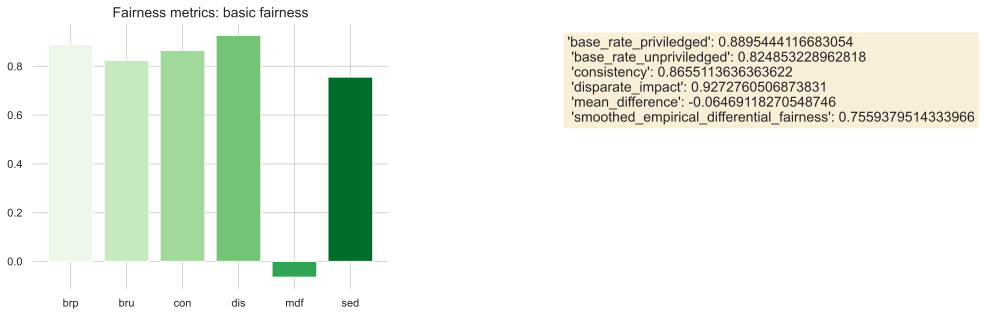

{'base_rate_priviledged': 0.8895444116683054,
 'base_rate_unpriviledged': 0.824853228962818,
 'consistency': 0.8655113636363622,
 'disparate_impact': 0.9272760506873831,
 'mean_difference': -0.06469118270548746,
 'smoothed_empirical_differential_fairness': 0.7559379514333966}

In [13]:
fairness_summary(bld_metric, description="basic fairness")

## One vs Rest analysis

## One vs Rest by Race

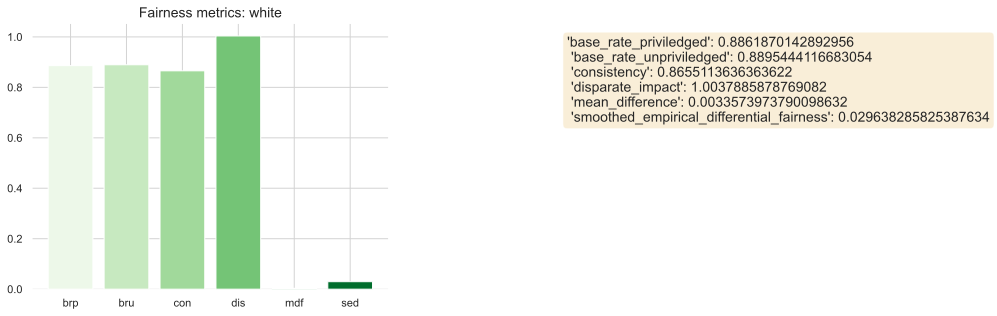

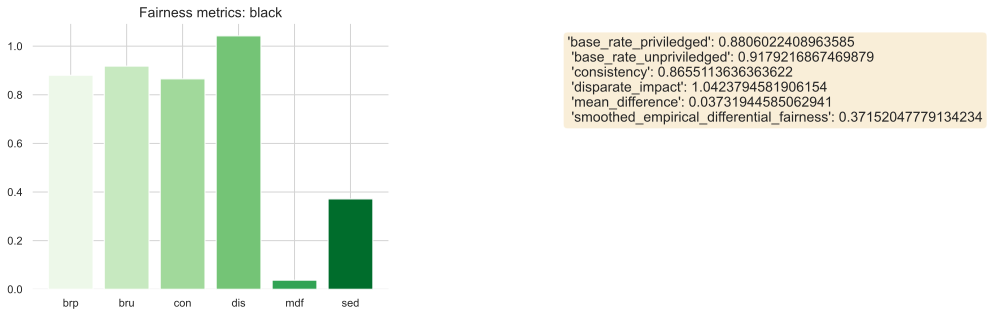

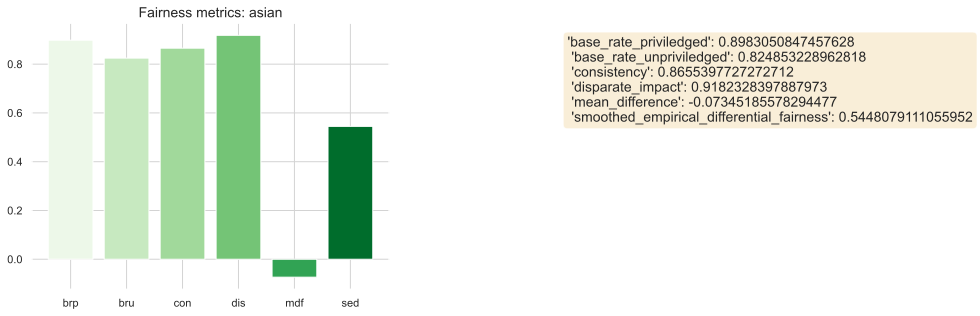

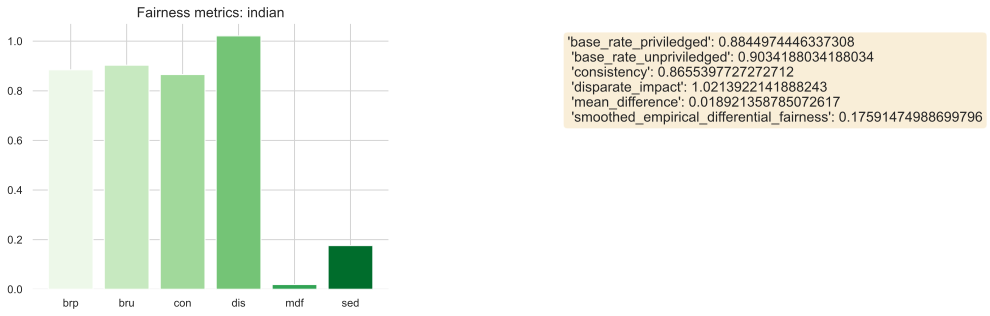

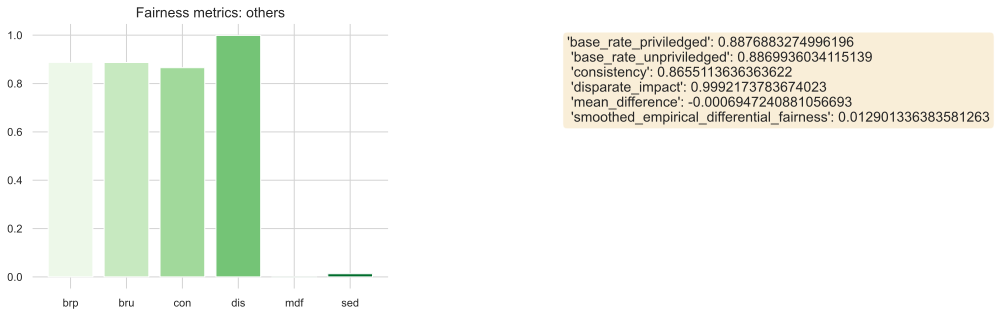

In [14]:
display(Markdown("## One vs Rest by Race"))


df_ovr_race = pd.DataFrame(columns=['group', 'base_rate_priviledged', 'base_rate_unpriviledged', 'consistency', 'disparate_impact', 'mean_difference', 'smoothed_empirical_differential_fairness'])

#onevsresst for race
for race_id, race_alias in dataset_dict['race_id'].items():
    df_sub = one_vs_rest_df(df_bld, conditions={'race': race_id})
    bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_sub, label_names=['pred_true'], protected_attribute_names=['group'])
    bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{'group': 0}], privileged_groups=[{'group': 1}])
    summary = fairness_summary(bld_metric, description=race_alias)
    summary['group'] = race_alias
    df_ovr_race = df_ovr_race.append(summary, ignore_index=True)



## One vs Rest by gender

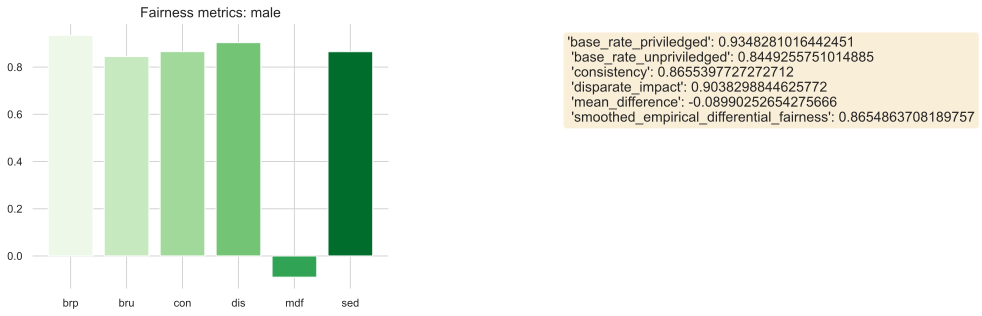

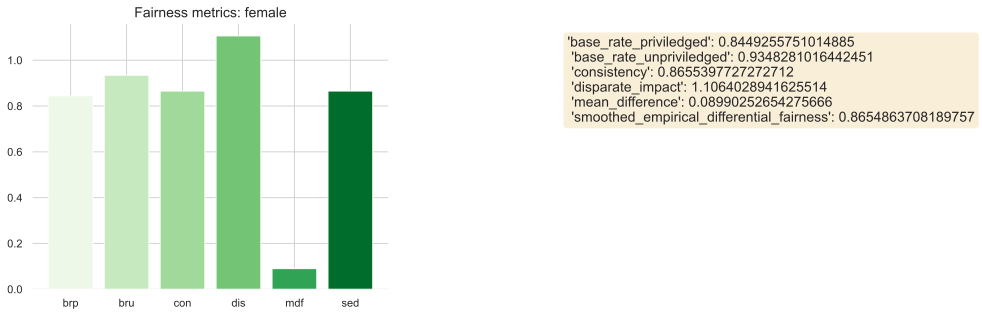

    group  base_rate_priviledged  base_rate_unpriviledged  consistency  \
0    male               0.934828                 0.844926      0.86554   
1  female               0.844926                 0.934828      0.86554   

   disparate_impact  mean_difference  smoothed_empirical_differential_fairness  
0          0.903830        -0.089903                                  0.865486  
1          1.106403         0.089903                                  0.865486  


In [15]:
#onevsresst for gender

display(Markdown("## One vs Rest by gender"))

df_ovr_gender = pd.DataFrame(columns=['group', 'base_rate_priviledged', 'base_rate_unpriviledged', 'consistency', 'disparate_impact', 'mean_difference', 'smoothed_empirical_differential_fairness'])

for gender_id, gender_alias in dataset_dict['gender_id'].items():
    df_sub = one_vs_rest_df(df_bld, conditions={'gender': gender_id})
    bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_sub, label_names=['pred_true'], protected_attribute_names=['group'])
    bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{'group': 0}], privileged_groups=[{'group': 1}])
    summary = fairness_summary(bld_metric, description=gender_alias)
    summary['group'] = gender_alias
    df_ovr_gender = df_ovr_gender.append(summary, ignore_index=True)

print(df_ovr_gender.head())


## One vs Rest by age

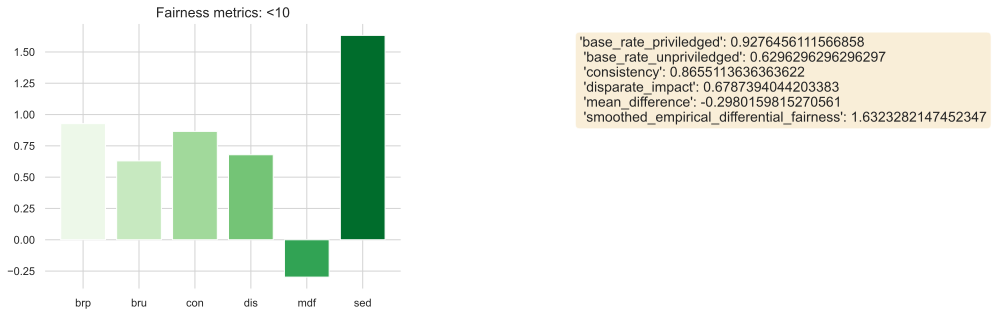

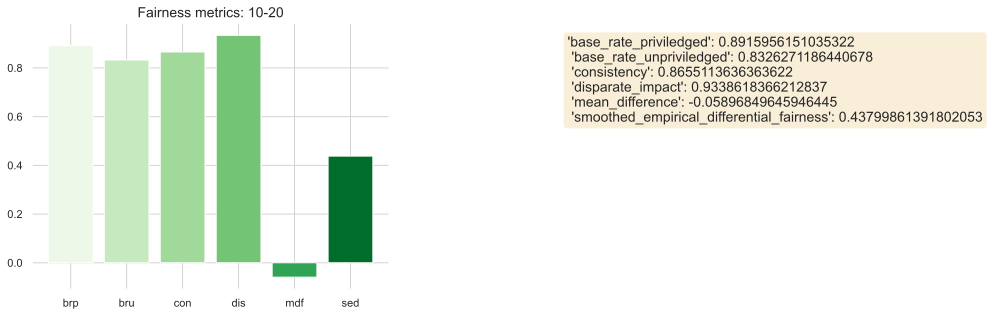

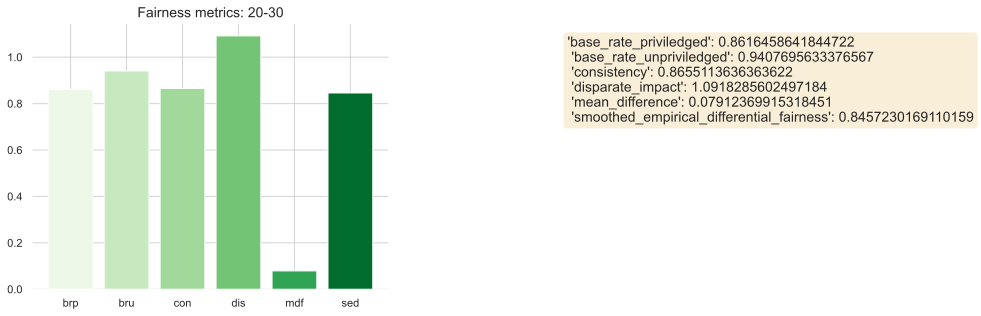

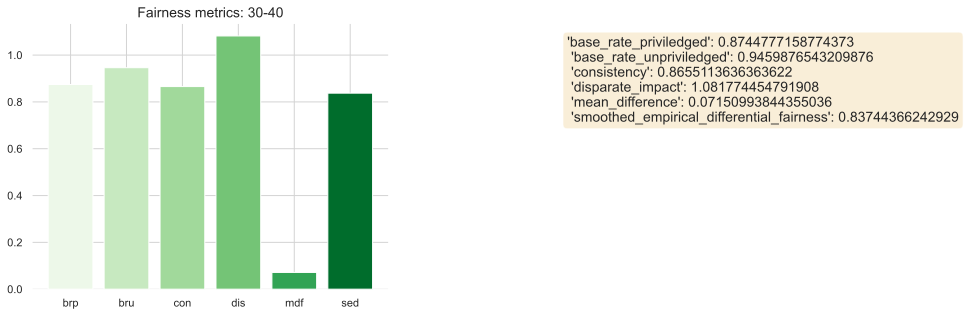

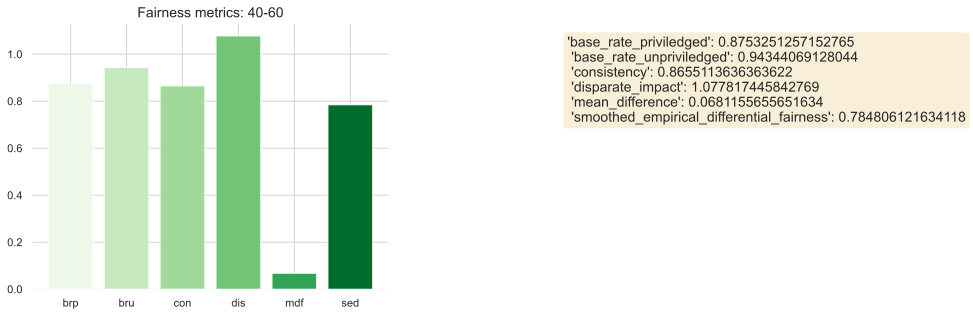

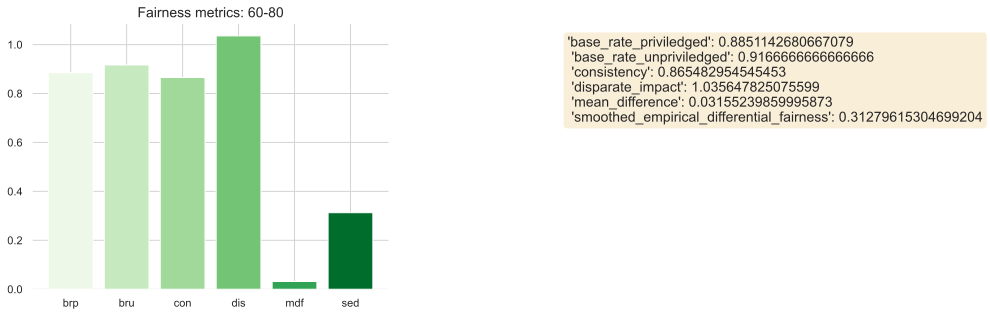

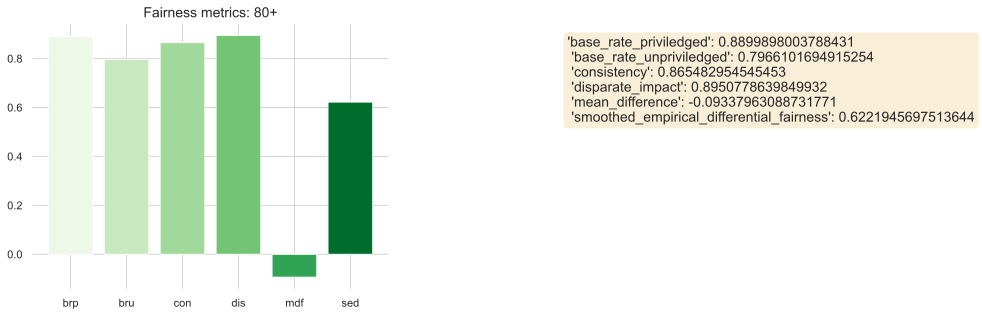

   group  base_rate_priviledged  base_rate_unpriviledged  consistency  \
0    <10               0.927646                 0.629630     0.865511   
1  10-20               0.891596                 0.832627     0.865511   
2  20-30               0.861646                 0.940770     0.865511   
3  30-40               0.874478                 0.945988     0.865511   
4  40-60               0.875325                 0.943441     0.865511   
5  60-80               0.885114                 0.916667     0.865483   
6    80+               0.889990                 0.796610     0.865483   

   disparate_impact  mean_difference  smoothed_empirical_differential_fairness  
0          0.678739        -0.298016                                  1.632328  
1          0.933862        -0.058968                                  0.437999  
2          1.091829         0.079124                                  0.845723  
3          1.081774         0.071510                                  0.837444  
4         

In [16]:
#onevsresst for age

display(Markdown("## One vs Rest by age"))

df_ovr_age = pd.DataFrame(columns=['group', 'base_rate_priviledged', 'base_rate_unpriviledged', 'consistency', 'disparate_impact', 'mean_difference', 'smoothed_empirical_differential_fairness'])

for age_id, age_alias in dataset_dict['age_id'].items():
    df_sub = one_vs_rest_df(df_bld, conditions={'age': age_id})
    bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_sub, label_names=['pred_true'], protected_attribute_names=['group'])
    bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{'group': 0}], privileged_groups=[{'group': 1}])
    summary = fairness_summary(bld_metric, description=age_alias)
    summary['group'] = age_alias
    df_ovr_age = df_ovr_age.append(summary, ignore_index=True)

print(df_ovr_age.head(10))

## Intersectional One vs Rest

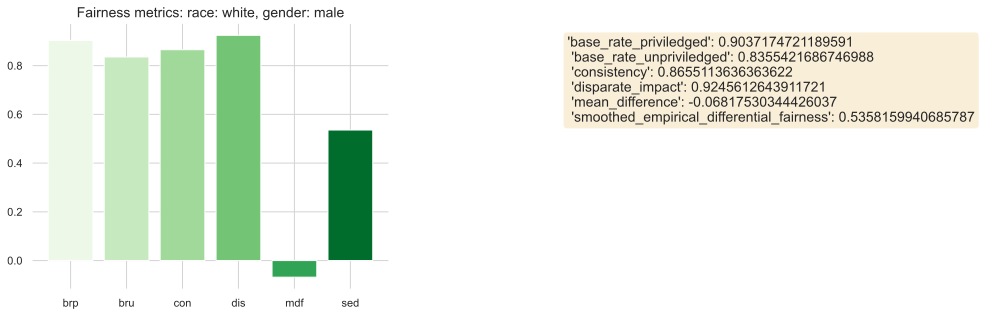

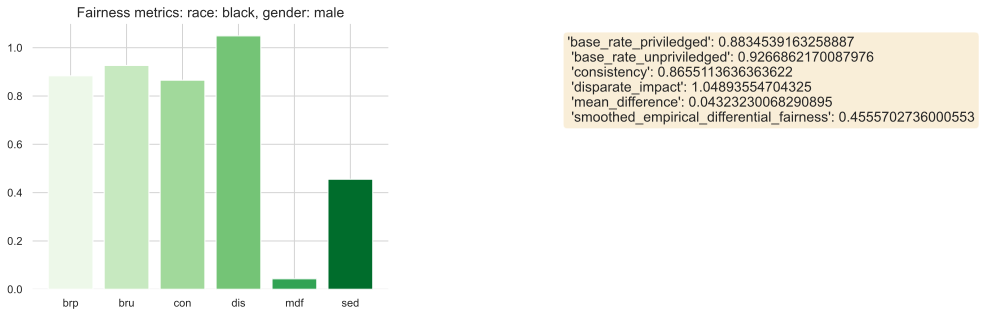

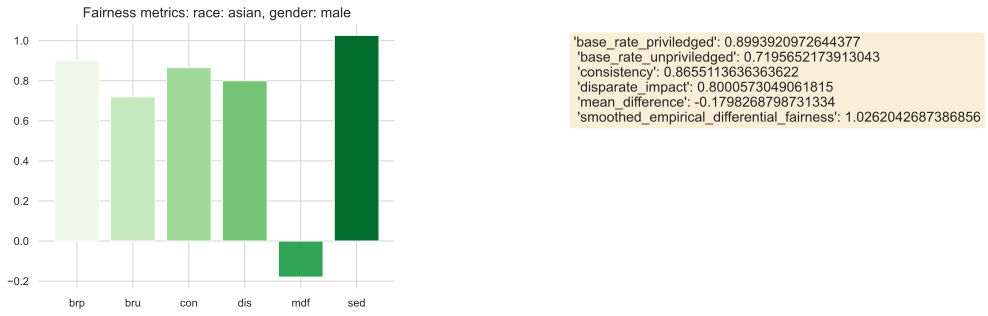

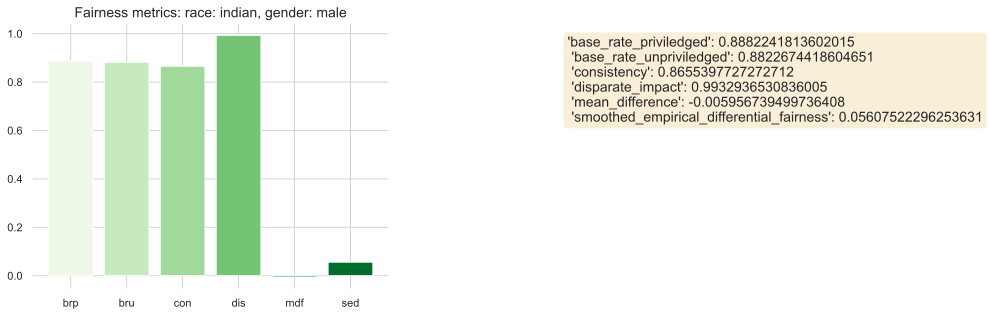

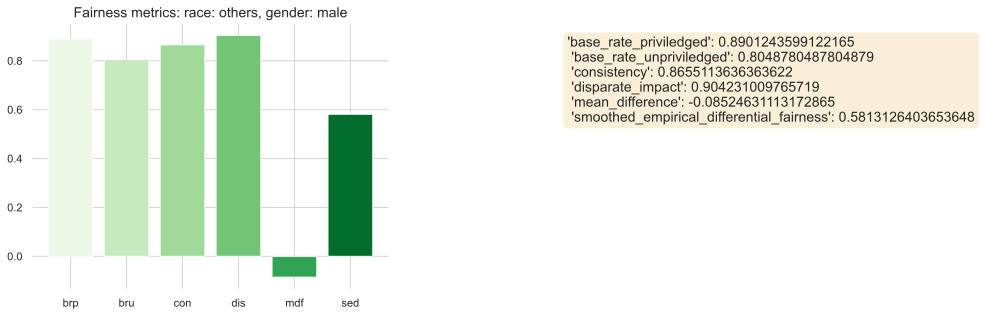

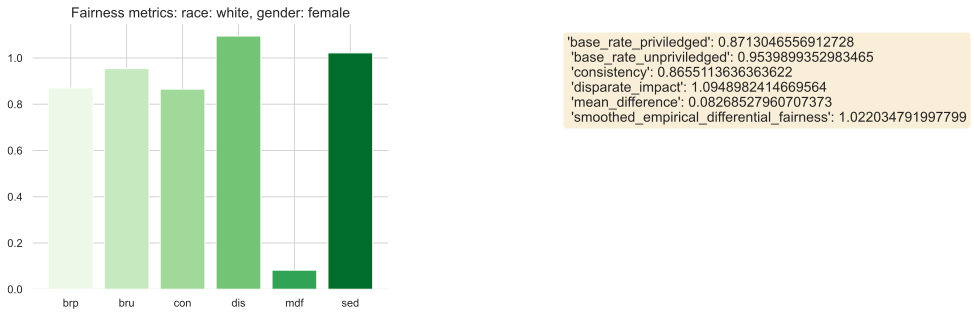

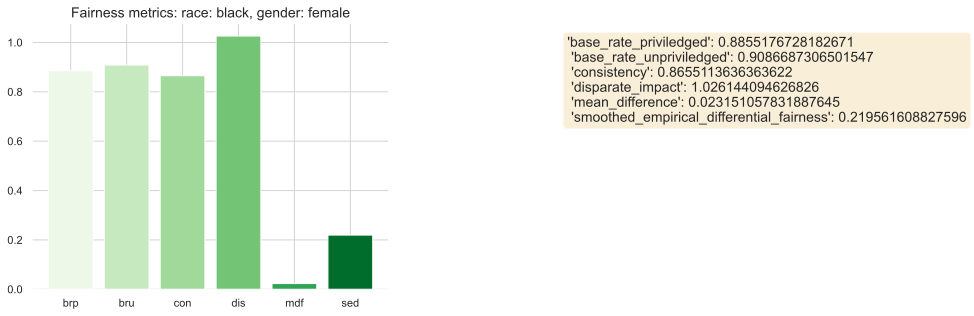

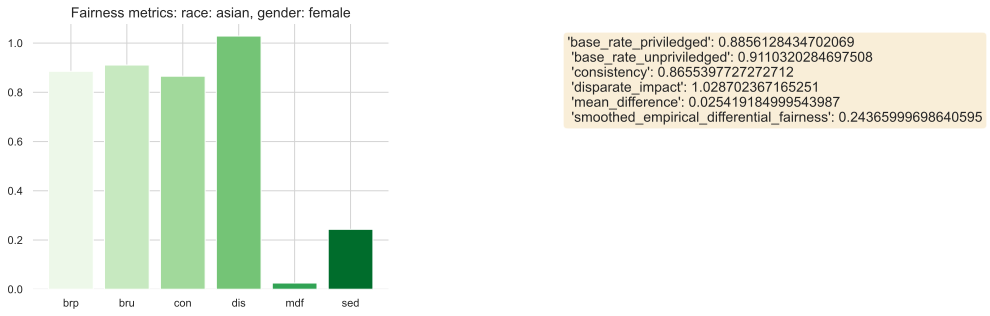

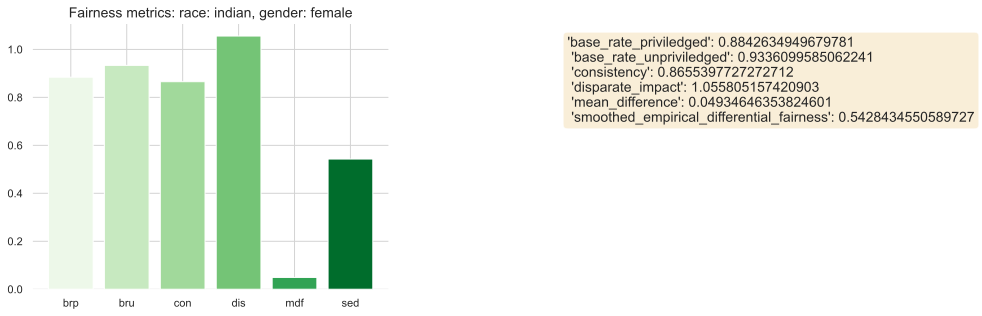

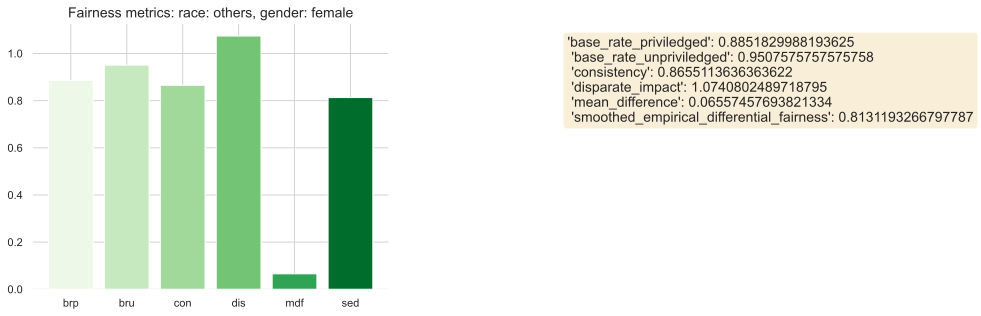

           group  base_rate_priviledged  base_rate_unpriviledged  consistency  \
0     male_white               0.903717                 0.835542     0.865511   
1     male_black               0.883454                 0.926686     0.865511   
2     male_asian               0.899392                 0.719565     0.865511   
3    male_indian               0.888224                 0.882267     0.865540   
4    male_others               0.890124                 0.804878     0.865511   
5   female_white               0.871305                 0.953990     0.865511   
6   female_black               0.885518                 0.908669     0.865511   
7   female_asian               0.885613                 0.911032     0.865540   
8  female_indian               0.884263                 0.933610     0.865540   
9  female_others               0.885183                 0.950758     0.865511   

   disparate_impact  mean_difference  smoothed_empirical_differential_fairness  
0          0.924561        

In [17]:
df_ovr_inter = pd.DataFrame(columns=['group', 'base_rate_priviledged', 'base_rate_unpriviledged', 'consistency', 'disparate_impact', 'mean_difference', 'smoothed_empirical_differential_fairness'])

for gender_id, gender_alias in dataset_dict['gender_id'].items():
    for race_id, race_alias in dataset_dict['race_id'].items():
        df_sub = one_vs_rest_df(df_bld, conditions={'race': race_id, 'gender': gender_id})
        bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_sub, label_names=['pred_true'], protected_attribute_names=['group'])
        bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{'group': 0}], privileged_groups=[{'group': 1}])
        summary = fairness_summary(bld_metric, description=f"race: {race_alias}, gender: {gender_alias}")
        summary['group'] = f"{gender_alias}_{race_alias}"
        df_ovr_inter = df_ovr_inter.append(summary, ignore_index=True)

print(df_ovr_inter.head(20))

## Plotting disparate impact

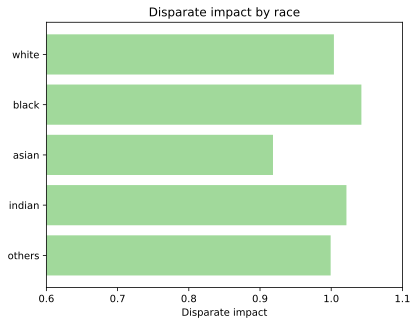

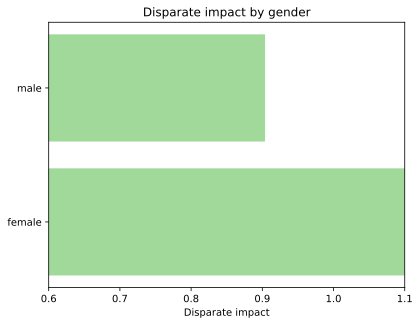

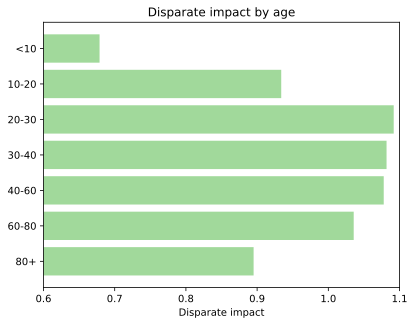

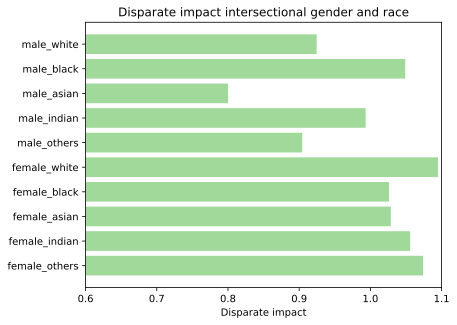

In [18]:
display(Markdown("## Plotting disparate impact"))

SAVE_PLOTS = False

def plot_disparate_impact(df, title):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    # Example data
    groups = df['group']
    y_pos = np.arange(len(groups))
    disparate_impact = df['disparate_impact']

    ax.barh(y_pos, disparate_impact, align='center', color=colors[2])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(groups)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Disparate impact')


    plt.xlim([0.6, 1.1])

    if SAVE_PLOTS:
        print(f"Saving: {title}")
        plt.savefig(f"Plots/disparate_impact/{title.lower().replace(' ', '_')}.png", dpi=300,bbox_inches='tight')
        plt.savefig(f"Plots/disparate_impact/{title.lower().replace(' ', '_')}.eps", format="eps",bbox_inches='tight')

    ax.set_title(title)
    plt.show()

plot_disparate_impact(df_ovr_race, 'Disparate impact by race')
plot_disparate_impact(df_ovr_gender, 'Disparate impact by gender')
plot_disparate_impact(df_ovr_age, 'Disparate impact by age')
plot_disparate_impact(df_ovr_inter, 'Disparate impact intersectional gender and race')